In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

In [2]:
df = pd.read_csv('D:/Proyectos Personales ML/Entrenamientos ML/BITCOIN/Bitcoin_2011_2017_Clean.csv')
df.head(3)


,Date,Price,Open,High,Low,Vol.,Change %
0,2017-12-31,969.4,969.4,996.0,841.5,111270.0,0.1052
1,2017-12-30,969.4,969.4,996.0,841.5,182070.0,-0.1293
2,2017-12-29,969.4,969.4,996.0,841.5,118880.0,-0.0004


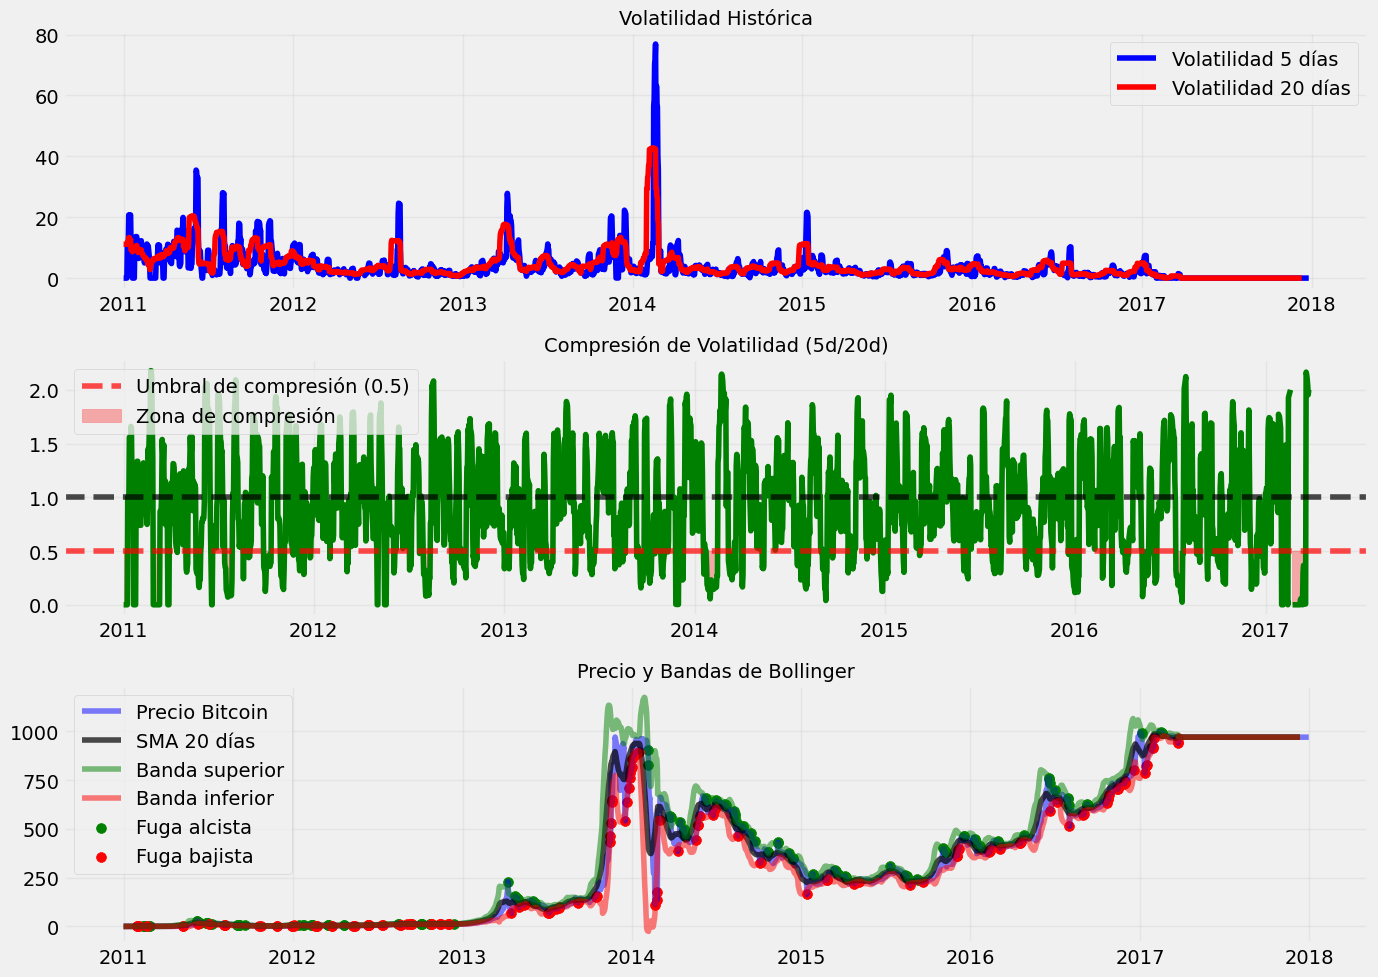

Rango promedio en 10 días después de compresión de volatilidad: 17.10%
Rango promedio en 10 días en períodos normales: 20.62%
Ratio: 0.83x


In [3]:
# Asumiendo que ya tenemos el dataframe 'df' con los datos de Bitcoin
# Si 'Date' no es el índice, lo establecemos como tal
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
# Configuración para visualizaciones
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (14, 8)
sns.set_palette('deep')

# Cálculo de retornos (ya que no existen en el dataframe original)
df['return_daily'] = df['Price'].pct_change() * 100
df['return_log'] = np.log(df['Price'] / df['Price'].shift(1)) * 100

# 1. Volatilidad histórica (diferentes ventanas)
df['volatility_5d'] = df['return_daily'].rolling(window=5).std()
df['volatility_20d'] = df['return_daily'].rolling(window=20).std()
df['volatility_50d'] = df['return_daily'].rolling(window=50).std()

# 2. Compresión de volatilidad (ratio entre volatilidad corta y larga)
df['volatility_compression'] = df['volatility_5d'] / df['volatility_20d']

# 3. Desviación de volatilidad respecto a su media
df['volatility_deviation'] = df['volatility_20d'] / df['volatility_20d'].rolling(window=50).mean()

# 4. Cambio en volatilidad (aceleración/desaceleración)
df['volatility_change'] = df['volatility_20d'].pct_change(5)

# 5. Volatilidad intradiaria (rango diario normalizado)
df['intraday_volatility'] = (df['High'] - df['Low']) / df['Open']

# 6. Ratio de rango diario (comparado con su promedio)
df['range_ratio'] = df['intraday_volatility'] / df['intraday_volatility'].rolling(window=20).mean()

# 7. Alerta de compresión de volatilidad (indicador binario)
volatility_threshold_low = 0.5
df['volatility_compression_alert'] = (df['volatility_compression'] < volatility_threshold_low).astype(int)

# 8. Bandas de Bollinger y fugas
df['sma_20'] = df['Price'].rolling(window=20).mean()
df['bollinger_std'] = df['Price'].rolling(window=20).std()
df['upper_band'] = df['sma_20'] + (df['bollinger_std'] * 2)
df['lower_band'] = df['sma_20'] - (df['bollinger_std'] * 2)
df['bollinger_breakout_up'] = (df['Price'] > df['upper_band']).astype(int)
df['bollinger_breakout_down'] = (df['Price'] < df['lower_band']).astype(int)

# 9. Visualización de volatilidad y compresión
plt.figure(figsize=(14, 10))
plt.subplot(3, 1, 1)
plt.plot(df.index, df['volatility_5d'], label='Volatilidad 5 días', color='blue')
plt.plot(df.index, df['volatility_20d'], label='Volatilidad 20 días', color='red')
plt.title('Volatilidad Histórica', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 2)
plt.plot(df.index, df['volatility_compression'], color='green')
plt.axhline(y=1, color='black', linestyle='--', alpha=0.7)
plt.axhline(y=volatility_threshold_low, color='red', linestyle='--', alpha=0.7, 
           label=f'Umbral de compresión ({volatility_threshold_low})')
plt.title('Compresión de Volatilidad (5d/20d)', fontsize=14)
plt.fill_between(df.index, df['volatility_compression'], volatility_threshold_low, 
                where=df['volatility_compression'] < volatility_threshold_low, 
                color='red', alpha=0.3, label='Zona de compresión')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 3)
plt.plot(df.index, df['Price'], color='blue', alpha=0.5, label='Precio Bitcoin')
plt.plot(df.index, df['sma_20'], color='black', alpha=0.7, label='SMA 20 días')
plt.plot(df.index, df['upper_band'], color='green', alpha=0.5, label='Banda superior')
plt.plot(df.index, df['lower_band'], color='red', alpha=0.5, label='Banda inferior')
plt.scatter(df[df['bollinger_breakout_up'] == 1].index, 
            df.loc[df['bollinger_breakout_up'] == 1, 'Price'], 
            color='green', s=50, label='Fuga alcista')
plt.scatter(df[df['bollinger_breakout_down'] == 1].index, 
            df.loc[df['bollinger_breakout_down'] == 1, 'Price'], 
            color='red', s=50, label='Fuga bajista')
plt.title('Precio y Bandas de Bollinger', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 10. Análisis de eventos posteriores a compresión de volatilidad
lookforward_days = 10
df['future_range'] = df['Price'].rolling(window=lookforward_days).max() / df['Price'].rolling(window=lookforward_days).min() - 1
df['future_range'] = df['future_range'].shift(-lookforward_days)

# Análisis estadístico
compression_events = df[df['volatility_compression_alert'] == 1]
normal_periods = df[df['volatility_compression_alert'] == 0]

if len(compression_events) > 0 and len(normal_periods) > 0:
    avg_movement_after_compression = compression_events['future_range'].mean() * 100
    avg_movement_normal = normal_periods['future_range'].mean() * 100
    
    print(f"Rango promedio en {lookforward_days} días después de compresión de volatilidad: {avg_movement_after_compression:.2f}%")
    print(f"Rango promedio en {lookforward_days} días en períodos normales: {avg_movement_normal:.2f}%")
    print(f"Ratio: {avg_movement_after_compression/avg_movement_normal:.2f}x")

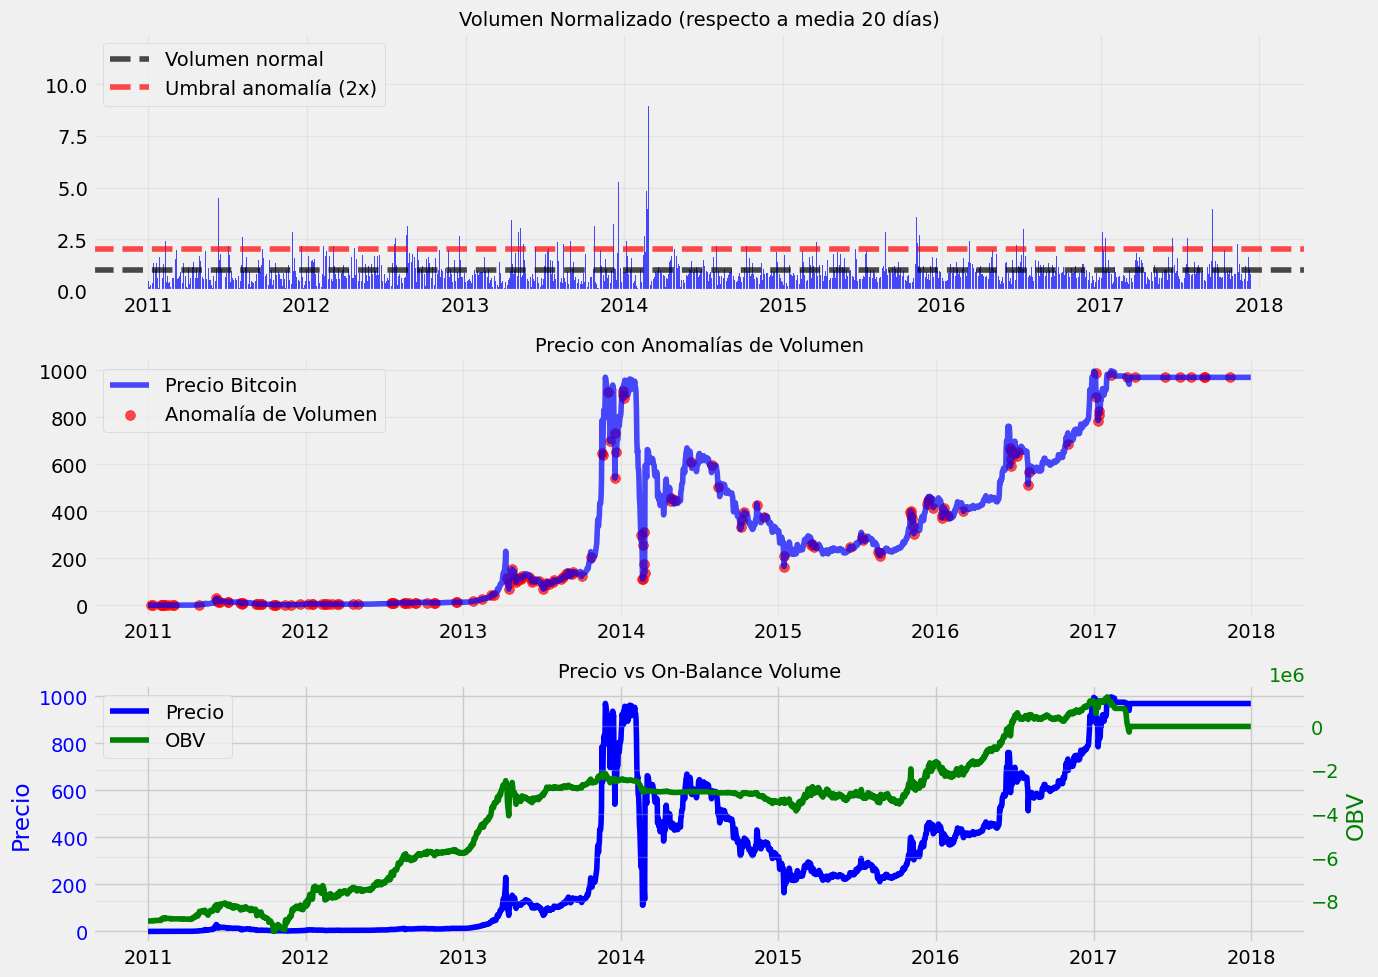

Retorno promedio 5 días después de anomalía de volumen: 8.58%
Retorno promedio 5 días en períodos normales: -1.30%
Diferencia: 9.88 puntos porcentuales


In [4]:
# 1. Volumen normalizado (respecto a medias móviles)
df['volume_norm_5d'] = df['Vol.'] / df['Vol.'].rolling(window=5).mean()
df['volume_norm_20d'] = df['Vol.'] / df['Vol.'].rolling(window=20).mean()

# 2. Anomalía de volumen (indicador binario para picos significativos)
volume_threshold = 2  # 2 veces el volumen promedio
df['volume_anomaly'] = (df['volume_norm_20d'] > volume_threshold).astype(int)

# 3. Acumulación/Distribución
# Primero calculamos el Money Flow Multiplier
df['mf_multiplier'] = ((df['Price'] - df['Low']) - (df['High'] - df['Price'])) / (df['High'] - df['Low'])
# Luego el Money Flow Volume
df['mf_volume'] = df['mf_multiplier'] * df['Vol.']
# Finalmente calculamos el indicador de Acumulación/Distribución acumulativo
df['acc_dist'] = df['mf_volume'].cumsum()

# 4. On-Balance Volume (OBV)
df['price_direction'] = np.where(df['Price'] > df['Price'].shift(1), 1, 
                               np.where(df['Price'] < df['Price'].shift(1), -1, 0))
df['obv_change'] = df['Vol.'] * df['price_direction']
df['obv'] = df['obv_change'].cumsum()

# 5. Divergencia precio-volumen (correlación en ventana móvil)
window_size = 10
df['price_vol_corr'] = df['Price'].rolling(window=window_size).corr(df['Vol.'])

# 6. Ratio días alcistas/bajistas por volumen
df['up_day'] = (df['Price'] > df['Price'].shift(1)).astype(int)
df['up_volume'] = df['Vol.'] * df['up_day']
df['down_volume'] = df['Vol.'] * (1 - df['up_day'])
df['up_down_vol_ratio'] = df['up_volume'].rolling(window=10).sum() / df['down_volume'].rolling(window=10).sum()

# 7. Presión compradora/vendedora
df['buying_pressure'] = ((df['Price'] - df['Low']) / (df['High'] - df['Low'])) * df['Vol.']
df['selling_pressure'] = ((df['High'] - df['Price']) / (df['High'] - df['Low'])) * df['Vol.']
df['pressure_ratio'] = df['buying_pressure'] / df['selling_pressure']

# 8. Indicador de agotamiento de volumen
df['volume_exhaustion'] = (df['Vol.'].rolling(window=5).mean() / df['Vol.'].rolling(window=20).mean() < 0.8).astype(int)

# 9. Visualización de volumen y anomalías
plt.figure(figsize=(14, 10))

# Gráfico de volumen normalizado
plt.subplot(3, 1, 1)
plt.bar(df.index, df['volume_norm_20d'], color='blue', alpha=0.7)
plt.axhline(y=1, color='black', linestyle='--', alpha=0.7, label='Volumen normal')
plt.axhline(y=volume_threshold, color='red', linestyle='--', alpha=0.7, label=f'Umbral anomalía ({volume_threshold}x)')
plt.title('Volumen Normalizado (respecto a media 20 días)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico de precio con indicadores de anomalía de volumen
plt.subplot(3, 1, 2)
plt.plot(df.index, df['Price'], color='blue', alpha=0.7, label='Precio Bitcoin')
plt.scatter(df[df['volume_anomaly'] == 1].index, 
           df.loc[df['volume_anomaly'] == 1, 'Price'], 
           color='red', s=50, alpha=0.7, label='Anomalía de Volumen')
plt.title('Precio con Anomalías de Volumen', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico de OBV vs Precio
plt.subplot(3, 1, 3)
ax1 = plt.gca()
ax1.plot(df.index, df['Price'], color='blue', label='Precio')
ax1.set_ylabel('Precio', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(df.index, df['obv'], color='green', label='OBV')
ax2.set_ylabel('OBV', color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Precio vs On-Balance Volume', fontsize=14)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 10. Análisis de rendimiento después de anomalías de volumen
future_days = 5
df['future_return'] = df['Price'].pct_change(future_days).shift(-future_days) * 100

# Estadísticas de retornos después de anomalías vs períodos normales
volume_anomaly_periods = df[df['volume_anomaly'] == 1]
normal_volume_periods = df[df['volume_anomaly'] == 0]

if len(volume_anomaly_periods) > 0 and len(normal_volume_periods) > 0:
    avg_return_after_anomaly = volume_anomaly_periods['future_return'].mean()
    avg_return_normal = normal_volume_periods['future_return'].mean()
    
    print(f"Retorno promedio {future_days} días después de anomalía de volumen: {avg_return_after_anomaly:.2f}%")
    print(f"Retorno promedio {future_days} días en períodos normales: {avg_return_normal:.2f}%")
    print(f"Diferencia: {avg_return_after_anomaly - avg_return_normal:.2f} puntos porcentuales")

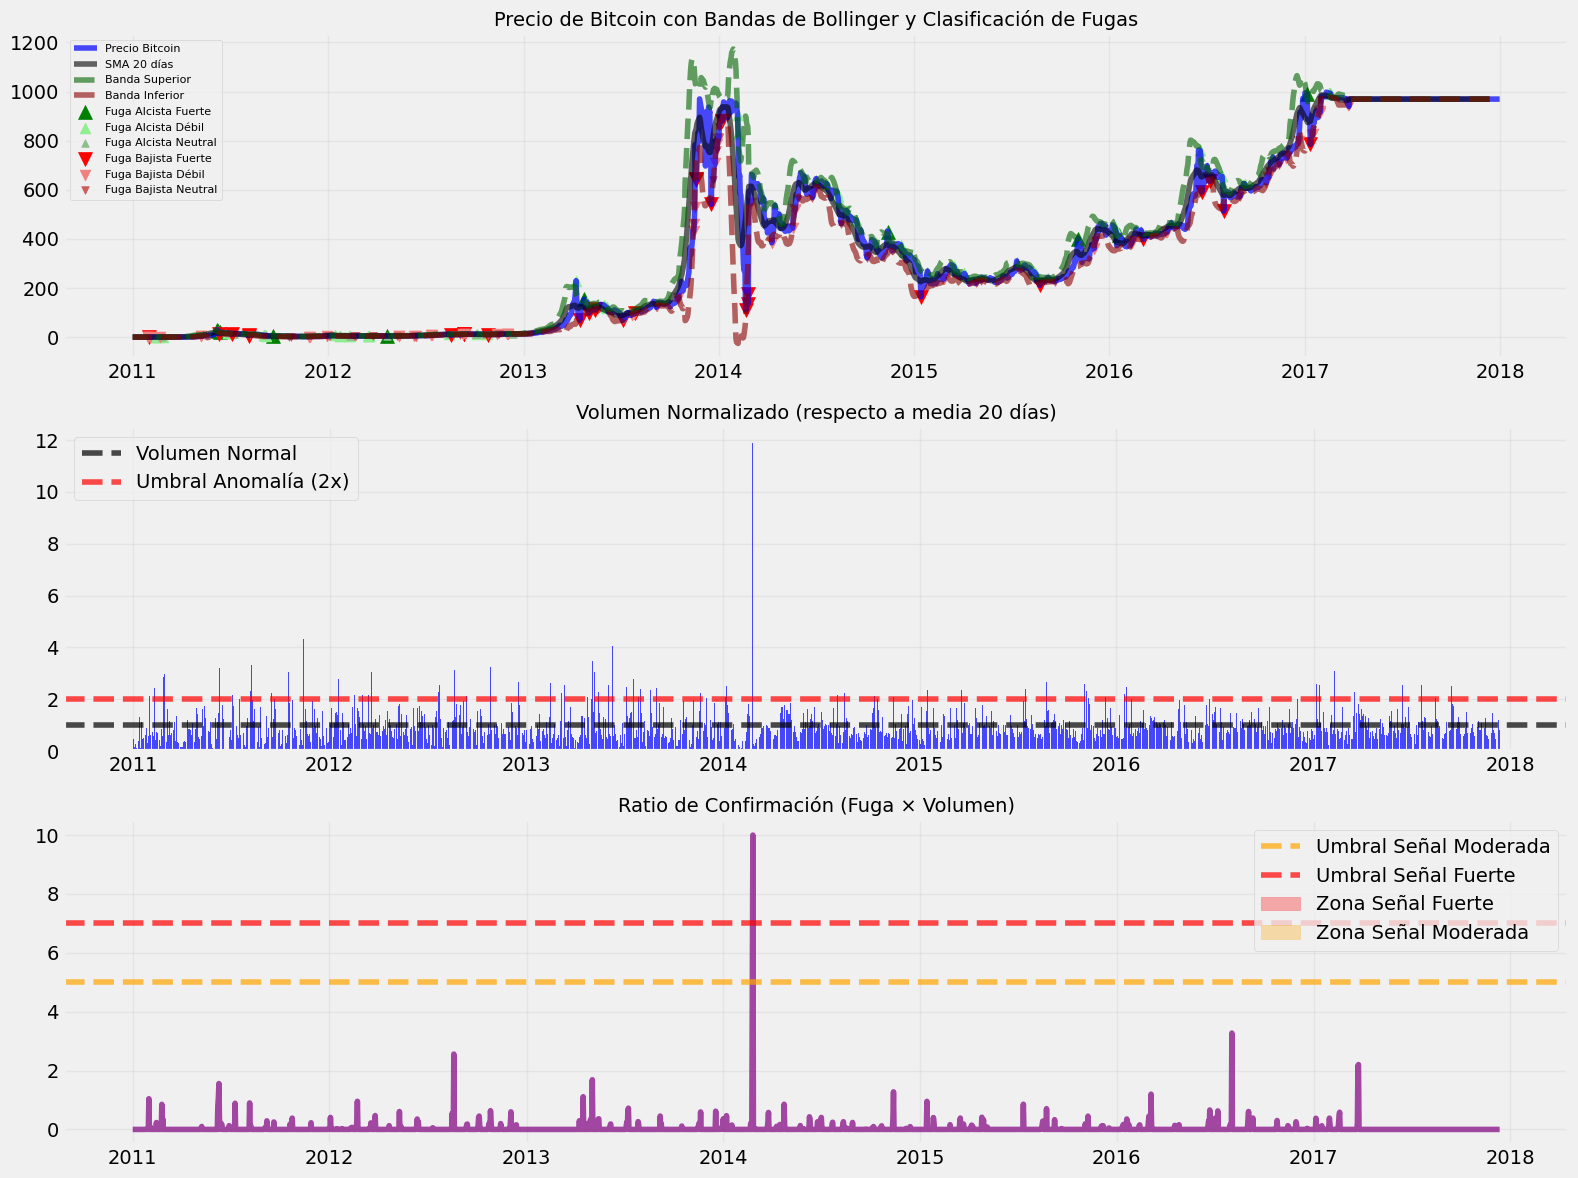


Análisis de Rendimiento por Tipo de Fuga:
              Tipo Retorno Promedio 5d Probabilidad Retorno Positivo  \
0    Fugas Fuertes              16.62%                         56.4%   
1    Fugas Débiles              -2.34%                         44.2%   
2  Fugas Neutrales               0.78%                         47.5%   
3        Sin Fugas              -0.91%                         34.2%   

   Cantidad de Señales  
0                   39  
1                  120  
2                  122  
3                 2276  


In [5]:
# Asumimos que 'df' ya tiene las Bandas de Bollinger y métricas de volumen calculadas
# Si no es así, aquí está el código necesario:

# 1. Cálculo de Bandas de Bollinger (si aún no están calculadas)
df['sma_20'] = df['Price'].rolling(window=20).mean()
df['bollinger_std'] = df['Price'].rolling(window=20).std()
df['upper_band'] = df['sma_20'] + (df['bollinger_std'] * 2)
df['lower_band'] = df['sma_20'] - (df['bollinger_std'] * 2)

# 2. Identificación de fugas
df['bollinger_breakout_up'] = (df['Price'] > df['upper_band']).astype(int)
df['bollinger_breakout_down'] = (df['Price'] < df['lower_band']).astype(int)
df['bollinger_breakout_any'] = ((df['bollinger_breakout_up'] + df['bollinger_breakout_down']) > 0).astype(int)

# 3. Volumen normalizado (si aún no está calculado)
df['volume_norm_20d'] = df['Vol.'] / df['Vol.'].rolling(window=20).mean()
df['volume_anomaly'] = (df['volume_norm_20d'] > 2).astype(int)  # Volumen más del doble del promedio

# 4. Nuevas métricas combinadas

# A. Distancia a la banda (cuánto se aleja el precio de la banda)
df['distance_to_upper'] = (df['Price'] - df['upper_band']) / df['bollinger_std']
df['distance_to_lower'] = (df['lower_band'] - df['Price']) / df['bollinger_std']
df['distance_to_band'] = np.where(df['bollinger_breakout_up'] == 1, df['distance_to_upper'], 
                                 np.where(df['bollinger_breakout_down'] == 1, df['distance_to_lower'], 0))

# B. Indicador combinado Fuga-Volumen 
df['breakout_with_volume'] = (df['bollinger_breakout_any'] & df['volume_anomaly']).astype(int)

# C. Ratio de Confirmación (combina magnitud de la fuga con ratio de volumen)
df['confirmation_ratio'] = df['distance_to_band'] * df['volume_norm_20d']
# Normalizamos a una escala más intuitiva (0-10)
if df['confirmation_ratio'].max() > 0:  # Evitamos división por cero
    df['confirmation_ratio'] = 10 * df['confirmation_ratio'] / df['confirmation_ratio'].max()

# D. Divergencia Fuga-Volumen (fuga con volumen bajo - potencial señal débil)
df['volume_declining'] = (df['volume_norm_20d'] < 0.8).astype(int)  # Volumen por debajo del 80% del promedio
df['breakout_with_weak_volume'] = (df['bollinger_breakout_any'] & df['volume_declining']).astype(int)

# E. Clasificación de Fugas
df['breakout_quality'] = np.where(df['breakout_with_volume'] == 1, 'Fuerte', 
                                 np.where(df['breakout_with_weak_volume'] == 1, 'Débil',
                                         np.where(df['bollinger_breakout_any'] == 1, 'Neutral', 'Sin Fuga')))

# 5. Visualización de fugas y volumen
plt.figure(figsize=(16, 12))

# Gráfico de precio con Bandas de Bollinger y fugas clasificadas
plt.subplot(3, 1, 1)
plt.plot(df.index, df['Price'], color='blue', alpha=0.7, label='Precio Bitcoin')
plt.plot(df.index, df['sma_20'], color='black', alpha=0.6, label='SMA 20 días')
plt.plot(df.index, df['upper_band'], color='darkgreen', linestyle='--', alpha=0.6, label='Banda Superior')
plt.plot(df.index, df['lower_band'], color='darkred', linestyle='--', alpha=0.6, label='Banda Inferior')

# Marcamos fugas según su calidad
strong_up = (df['breakout_with_volume'] == 1) & (df['bollinger_breakout_up'] == 1)
weak_up = (df['breakout_with_weak_volume'] == 1) & (df['bollinger_breakout_up'] == 1)
neutral_up = (df['bollinger_breakout_up'] == 1) & (~strong_up) & (~weak_up)

strong_down = (df['breakout_with_volume'] == 1) & (df['bollinger_breakout_down'] == 1)
weak_down = (df['breakout_with_weak_volume'] == 1) & (df['bollinger_breakout_down'] == 1)
neutral_down = (df['bollinger_breakout_down'] == 1) & (~strong_down) & (~weak_down)

plt.scatter(df[strong_up].index, df.loc[strong_up, 'Price'], color='green', s=100, marker='^', label='Fuga Alcista Fuerte')
plt.scatter(df[weak_up].index, df.loc[weak_up, 'Price'], color='lightgreen', s=60, marker='^', label='Fuga Alcista Débil')
plt.scatter(df[neutral_up].index, df.loc[neutral_up, 'Price'], color='darkseagreen', s=30, marker='^', label='Fuga Alcista Neutral')

plt.scatter(df[strong_down].index, df.loc[strong_down, 'Price'], color='red', s=100, marker='v', label='Fuga Bajista Fuerte')
plt.scatter(df[weak_down].index, df.loc[weak_down, 'Price'], color='lightcoral', s=60, marker='v', label='Fuga Bajista Débil')
plt.scatter(df[neutral_down].index, df.loc[neutral_down, 'Price'], color='indianred', s=30, marker='v', label='Fuga Bajista Neutral')

plt.title('Precio de Bitcoin con Bandas de Bollinger y Clasificación de Fugas', fontsize=14)
plt.legend(fontsize=8, loc='upper left')
plt.grid(True, alpha=0.3)

# Gráfico de volumen normalizado
plt.subplot(3, 1, 2)
plt.bar(df.index, df['volume_norm_20d'], color='blue', alpha=0.7)
plt.axhline(y=1, color='black', linestyle='--', alpha=0.7, label='Volumen Normal')
plt.axhline(y=2, color='red', linestyle='--', alpha=0.7, label='Umbral Anomalía (2x)')
plt.title('Volumen Normalizado (respecto a media 20 días)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Gráfico del ratio de confirmación
plt.subplot(3, 1, 3)
plt.plot(df.index, df['confirmation_ratio'], color='purple', alpha=0.7)
plt.axhline(y=5, color='orange', linestyle='--', alpha=0.7, label='Umbral Señal Moderada')
plt.axhline(y=7, color='red', linestyle='--', alpha=0.7, label='Umbral Señal Fuerte')
plt.fill_between(df.index, df['confirmation_ratio'], 7, where=df['confirmation_ratio'] >= 7, 
                color='red', alpha=0.3, label='Zona Señal Fuerte')
plt.fill_between(df.index, df['confirmation_ratio'], 5, where=(df['confirmation_ratio'] >= 5) & (df['confirmation_ratio'] < 7), 
                color='orange', alpha=0.3, label='Zona Señal Moderada')
plt.title('Ratio de Confirmación (Fuga × Volumen)', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6. Análisis de rendimiento según calidad de fuga
future_days = 5
df['future_return'] = df['Price'].pct_change(future_days).shift(-future_days) * 100

# Calcular retornos promedios según tipo de fuga
strong_breakouts = df[df['breakout_with_volume'] == 1]
weak_breakouts = df[df['breakout_with_weak_volume'] == 1]
neutral_breakouts = df[(df['bollinger_breakout_any'] == 1) & (df['breakout_with_volume'] == 0) & (df['breakout_with_weak_volume'] == 0)]
no_breakouts = df[df['bollinger_breakout_any'] == 0]

# Asegurarse de que hay datos en cada categoría antes de calcular promedios
results = []
categories = [
    ('Fugas Fuertes', strong_breakouts),
    ('Fugas Débiles', weak_breakouts),
    ('Fugas Neutrales', neutral_breakouts),
    ('Sin Fugas', no_breakouts)
]

for name, data in categories:
    if not data.empty:
        avg_return = data['future_return'].mean()
        positive_prob = (data['future_return'] > 0).mean() * 100
        results.append({
            'Tipo': name,
            f'Retorno Promedio {future_days}d': f'{avg_return:.2f}%',
            'Probabilidad Retorno Positivo': f'{positive_prob:.1f}%',
            'Cantidad de Señales': len(data)
        })

if results:
    results_df = pd.DataFrame(results)
    print("\nAnálisis de Rendimiento por Tipo de Fuga:")
    print(results_df)

Análisis de valores nulos:
                        Null Count  Null Percentage
distance_to_upper              285        11.145874
distance_to_lower              285        11.145874
volatility_compression         284        11.106766
volatility_deviation           281        10.989441
volatility_change              281        10.989441
price_vol_corr                 255         9.972624
pressure_ratio                  64         2.502933
acc_dist                        64         2.502933
mf_volume                       64         2.502933
selling_pressure                64         2.502933
mf_multiplier                   64         2.502933
buying_pressure                 64         2.502933
volatility_50d                  50         1.955417
volatility_20d                  20         0.782167
confirmation_ratio              19         0.743058
range_ratio                     19         0.743058
sma_20                          19         0.743058
volume_norm_20d                 19   

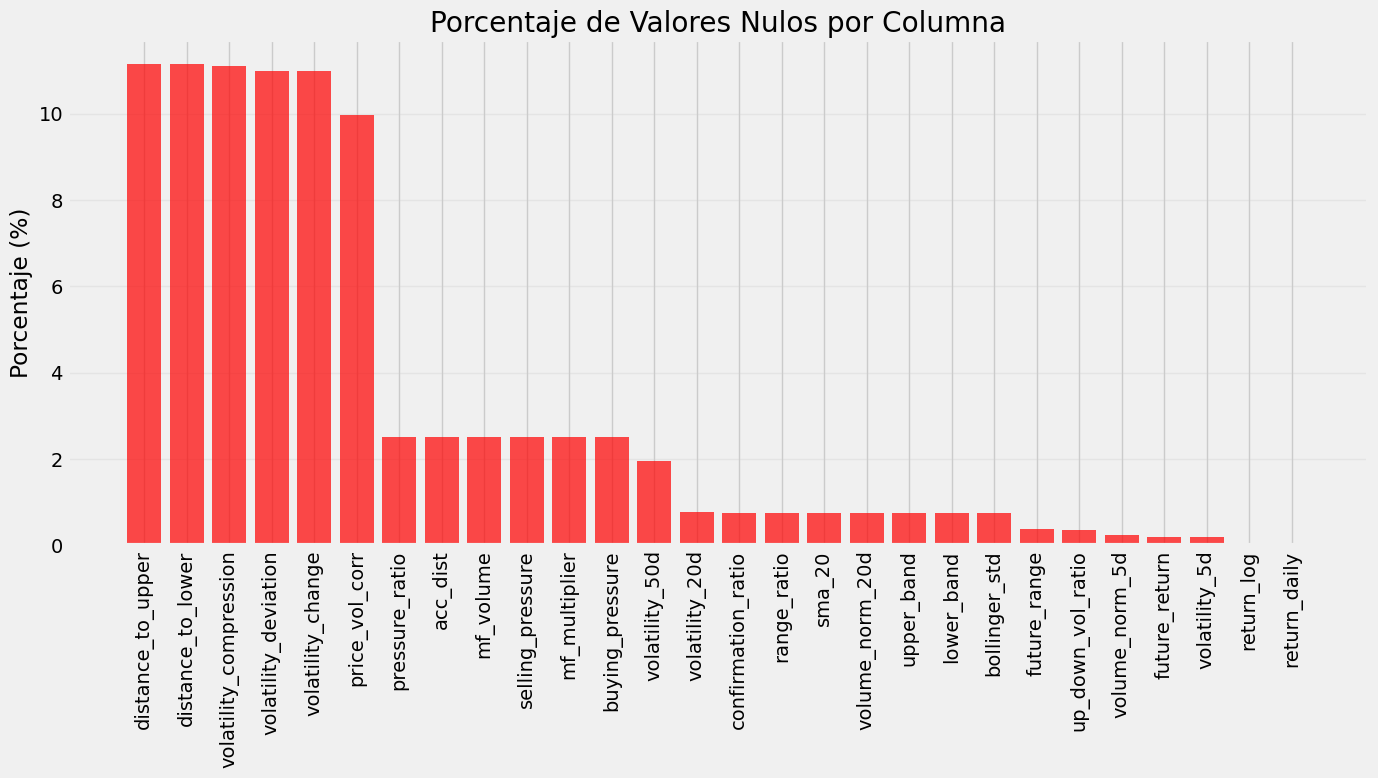

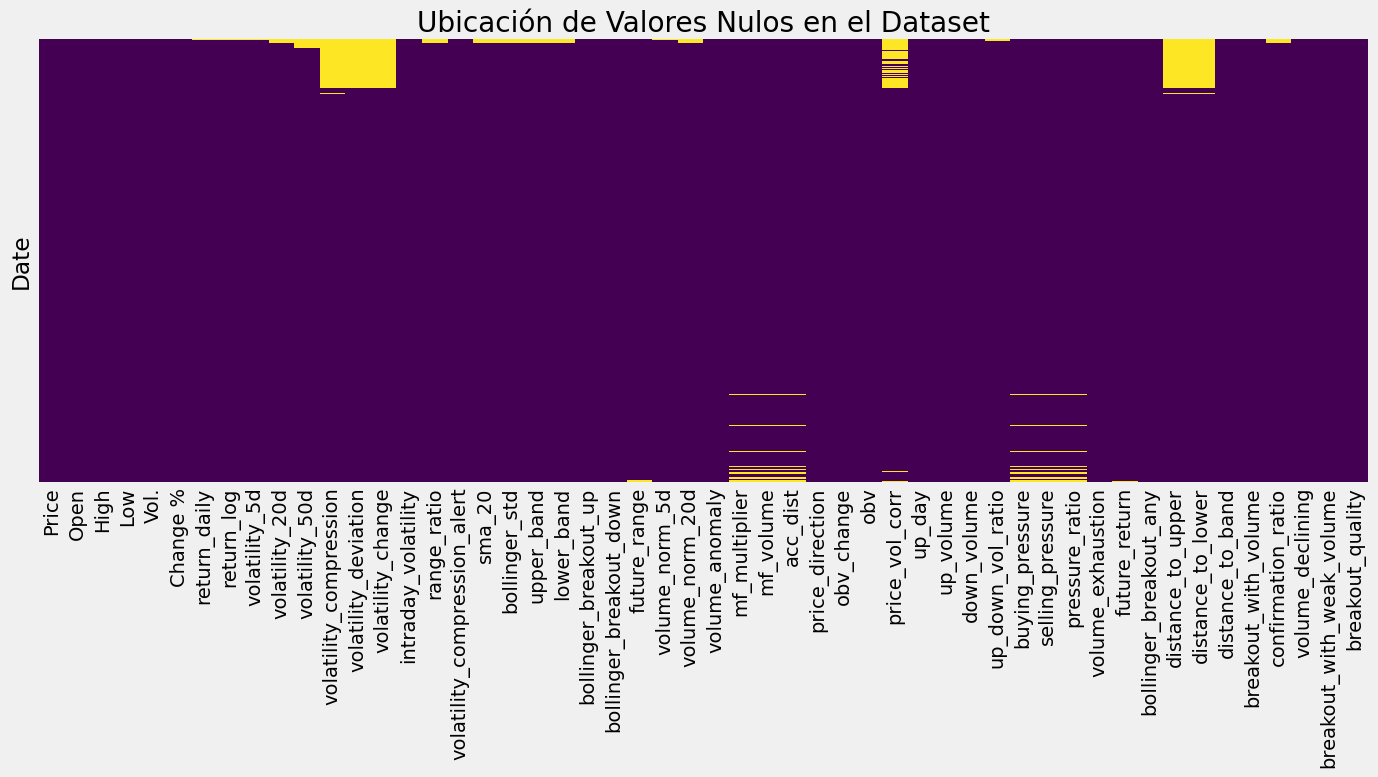


Filas originales: 2557
Filas después de eliminar nulos en features clave: 2273
Reducción: 284 filas (11.11%)

Primer índice con datos completos: 281
Filas si recortamos el inicio: 2276

Dimensiones del dataset limpio: (2276, 52)
Verificación de nulos restantes: 3


In [7]:
# 1. Verificar cantidad de valores nulos por columna
null_counts = df.isnull().sum()
null_percentage = (df.isnull().sum() / len(df)) * 100

null_info = pd.DataFrame({
    'Null Count': null_counts,
    'Null Percentage': null_percentage
}).sort_values('Null Count', ascending=False)

print("Análisis de valores nulos:")
print(null_info[null_info['Null Count'] > 0])  # Solo mostrar columnas con nulos

# 2. Visualizar la distribución de valores nulos
plt.figure(figsize=(14, 8))
plt.bar(null_info[null_info['Null Count'] > 0].index, 
        null_info[null_info['Null Count'] > 0]['Null Percentage'],
        color='red', alpha=0.7)
plt.xticks(rotation=90)
plt.title('Porcentaje de Valores Nulos por Columna')
plt.ylabel('Porcentaje (%)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Visualizar la ubicación de valores nulos en el dataset
plt.figure(figsize=(14, 8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Ubicación de Valores Nulos en el Dataset')
plt.tight_layout()
plt.show()

# 4. Analizar cuántos datos quedarían después de eliminar nulos
# Primero identificamos las features clave que usaremos en el modelo
key_features = [
    'return_daily', 'volatility_5d', 'volatility_20d', 'volatility_compression',
    'bollinger_breakout_up', 'bollinger_breakout_down', 
    'volume_norm_20d', 'distance_to_band', 'confirmation_ratio',
    'breakout_with_volume', 'breakout_with_weak_volume'
]

# Verificar cuántas filas quedarían si eliminamos nulos en features clave
rows_after_dropping = len(df.dropna(subset=key_features))
print(f"\nFilas originales: {len(df)}")
print(f"Filas después de eliminar nulos en features clave: {rows_after_dropping}")
print(f"Reducción: {len(df) - rows_after_dropping} filas ({(1 - rows_after_dropping/len(df))*100:.2f}%)")

# 5. Evaluar si podemos rellenar algunos nulos en lugar de eliminar filas
# Los nulos principalmente se deben a ventanas móviles al inicio del dataset
# Alternativa: Recortar el inicio del dataset donde las ventanas móviles generan nulos

# Encontrar el primer índice donde todas las features clave tienen valores
first_complete_idx = 0
for i in range(len(df)):
    if not df.iloc[i][key_features].isnull().any():
        first_complete_idx = i
        break

print(f"\nPrimer índice con datos completos: {first_complete_idx}")
print(f"Filas si recortamos el inicio: {len(df) - first_complete_idx}")

# 6. Crear un dataset limpio para modelado recortando el inicio
clean_df = df.iloc[first_complete_idx:].copy()
print(f"\nDimensiones del dataset limpio: {clean_df.shape}")
print(f"Verificación de nulos restantes: {clean_df[key_features].isnull().sum().sum()}")

In [7]:
clean_df.shape

(2276, 52)

In [11]:
# Eliminar variables duplicadas y altamente correlacionadas

# 1. Eliminar duplicados exactos (conservando solo una de cada variable)
# Lista de variables duplicadas detectadas en la matriz de correlación
duplicate_vars = [
    'breakout_Fuerte', 'breakout_Débil', 'breakout_Neutral', 'breakout_Sin Fuga'
]

# Creamos una lista para rastrear qué variables hemos procesado
processed_vars = []

# Lista final de variables a mantener
features_to_keep = []

for col in clean_df.columns:
    # Si la columna es una de las que tienen duplicados
    if col in duplicate_vars:
        # Si ya hemos procesado esta variable, la saltamos
        if col in processed_vars:
            continue
        # Si no, la marcamos como procesada y la conservamos
        processed_vars.append(col)
        features_to_keep.append(col)
    else:
        # Si no está en la lista de duplicados, la conservamos
        features_to_keep.append(col)

# 2. Resolver variables conceptualmente similares
# Preferimos los nombres más descriptivos
if 'breakout_Fuerte' in features_to_keep and 'breakout_with_volume' in features_to_keep:
    features_to_keep.remove('breakout_with_volume')
    
if 'breakout_Débil' in features_to_keep and 'breakout_with_weak_volume' in features_to_keep:
    features_to_keep.remove('breakout_with_weak_volume')

# 3. Crear un nuevo dataframe limpio con las variables seleccionadas
clean_model_df = clean_df[features_to_keep].copy()

print(f"Variables originales: {clean_df.shape[1]}")
print(f"Variables después de eliminar duplicados: {len(features_to_keep)}")
print(f"Reducción: {clean_df.shape[1] - len(features_to_keep)} variables")

# 4. Seleccionar las features finales para modelado
model_features = [
    # Features de volatilidad
    'volatility_compression', 'volatility_20d', 
    # Features de Bollinger
    'distance_to_band', 'bollinger_breakout_up', 'bollinger_breakout_down',
    # Features de volumen
    'volume_norm_20d', 
    # Features combinadas
    'confirmation_ratio',
    # Features de clasificación de fugas
    'breakout_Fuerte', 'breakout_Débil', 'breakout_Neutral', 'breakout_Sin Fuga'
]

# Asegurar que todas las features seleccionadas existen en el dataframe limpio
model_features = [f for f in model_features if f in clean_model_df.columns]

# 5. Verificar la nueva matriz de correlación
correlation_matrix = clean_model_df[model_features].corr()

print("\nMatriz de correlación después de eliminar duplicados:")
print(correlation_matrix.round(2))



Variables originales: 52
Variables después de eliminar duplicados: 52
Reducción: 0 variables

Matriz de correlación después de eliminar duplicados:
                         volatility_compression  volatility_20d  \
volatility_compression                     1.00           -0.09   
volatility_20d                            -0.09            1.00   
distance_to_band                           0.28           -0.02   
bollinger_breakout_up                      0.21            0.00   
bollinger_breakout_down                    0.19           -0.04   
volume_norm_20d                            0.21           -0.01   
confirmation_ratio                         0.17            0.05   

                         distance_to_band  bollinger_breakout_up  \
volatility_compression               0.28                   0.21   
volatility_20d                      -0.02                   0.00   
distance_to_band                     1.00                   0.47   
bollinger_breakout_up                0.47  

### VERIFICACIONES DE NULOS Y LUEGO IMPORTANCIA DE FEATURES PARA EL MODELADO

In [12]:
clean_model_df.describe()

,Price,Open,High,Low,Vol.,Change %,return_daily,return_log,volatility_5d,volatility_20d,...,volume_exhaustion,future_return,bollinger_breakout_any,distance_to_upper,distance_to_lower,distance_to_band,breakout_with_volume,confirmation_ratio,volume_declining,breakout_with_weak_volume
count,2276.000000,2276.000000,2276.000000,2276.000000,2276.000000,2276.000000,2276.000000,2276.000000,2276.000000,2276.000000,...,2276.000000,2271.000000,2276.000000,2272.000000,2272.000000,2276.000000,2276.000000,2276.000000,2276.000000,2276.000000
mean,286.943915,286.519486,294.201974,278.934159,47923.361160,0.006323,-0.115930,-0.355037,4.154486,4.762198,...,0.296134,-0.698271,0.123462,-2.213053,-1.786947,0.048586,0.017135,0.037271,0.450351,0.052724
std,286.647998,286.356671,292.878185,280.107110,48510.306734,0.096029,6.980013,7.082724,5.700727,5.027438,...,0.456651,15.258404,0.329039,1.357852,1.357852,0.191004,0.129804,0.279299,0.497638,0.223531
min,0.300000,0.300000,0.300000,0.300000,0.000000,-0.572100,-77.103355,-147.417980,0.000000,0.000000,...,0.000000,-81.183612,0.000000,-6.248529,-6.248529,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.300000,11.275000,11.700000,10.900000,17277.500000,-0.011000,-1.785714,-1.801851,1.362506,1.935456,...,0.000000,-5.855879,0.000000,-3.282011,-2.935957,0.000000,0.000000,0.000000,0.000000,0.000000
50%,234.850000,234.700000,238.800000,230.350000,36805.000000,0.000000,0.000000,0.000000,2.549782,3.293178,...,0.000000,-0.713287,0.000000,-2.490052,-1.509948,0.000000,0.000000,0.000000,0.000000,0.000000
75%,458.200000,457.950000,470.450000,449.700000,61762.500000,0.019125,1.150269,1.143703,4.766634,5.604819,...,1.000000,3.007519,0.000000,-1.064043,-0.717989,0.000000,0.000000,0.000000,1.000000,0.000000
max,997.600000,997.600000,996.000000,999.700000,572350.000000,3.368400,133.690795,84.882867,76.907490,42.781181,...,1.000000,231.635389,1.000000,2.248529,2.248529,2.248529,1.000000,10.000000,1.000000,1.000000


Columnas con valores NaN persistentes:
volatility_compression: 3 valores nulos
future_range: 10 valores nulos
volume_norm_5d: 2 valores nulos
mf_multiplier: 64 valores nulos
mf_volume: 64 valores nulos
acc_dist: 64 valores nulos
price_vol_corr: 20 valores nulos
buying_pressure: 64 valores nulos
selling_pressure: 64 valores nulos
pressure_ratio: 64 valores nulos
future_return: 5 valores nulos
distance_to_upper: 4 valores nulos
distance_to_lower: 4 valores nulos


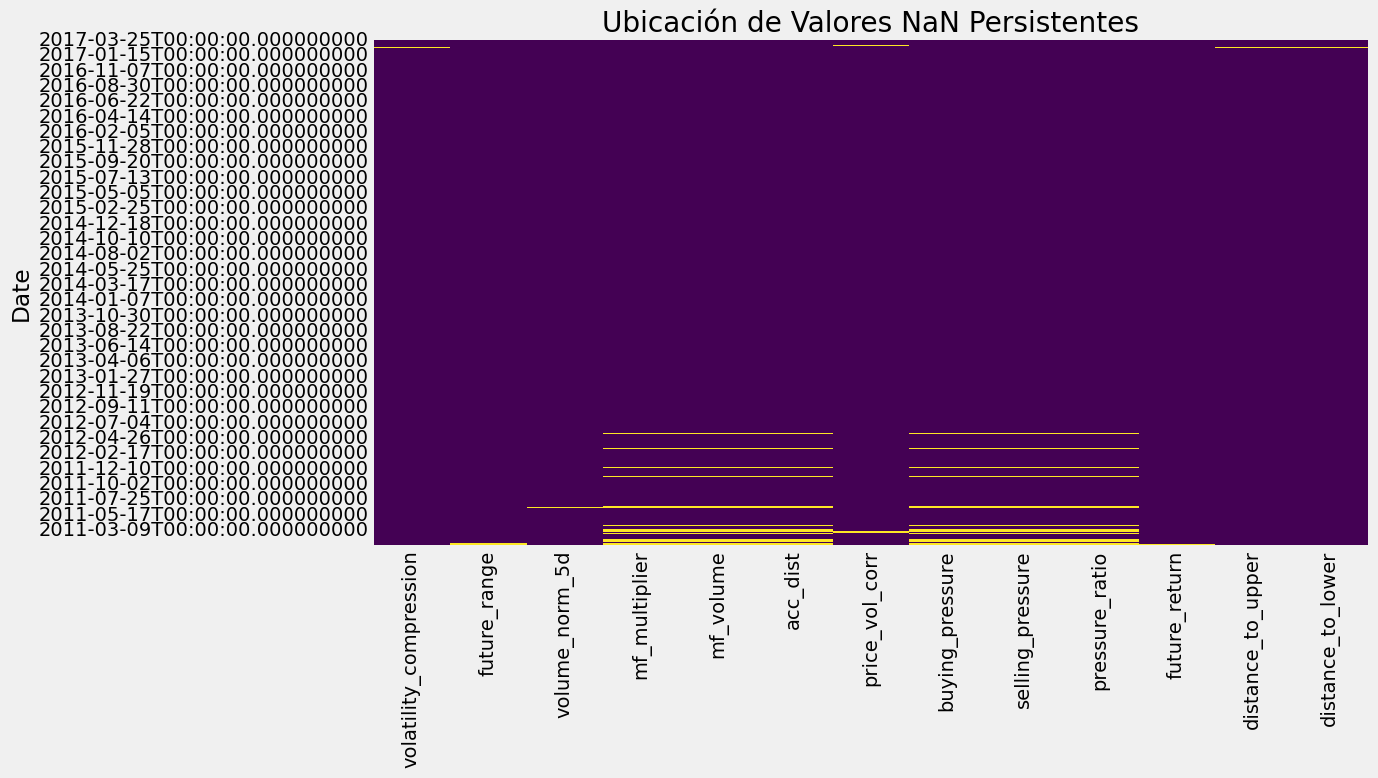


Opción 1 - Eliminar filas con cualquier NaN:
Filas originales en clean_df: 2276
Filas después de eliminar todos los NaN: 2198
Reducción: 78 filas (3.43%)

Separación de columnas con NaN:
Features técnicas: ['volatility_compression', 'volume_norm_5d', 'pressure_ratio']
Features de precio directo: ['future_range', 'mf_multiplier', 'mf_volume', 'acc_dist', 'price_vol_corr', 'buying_pressure', 'selling_pressure', 'future_return', 'distance_to_upper', 'distance_to_lower']

Opción 2 - Forward fill para features técnicas y eliminar resto:
Filas después de estrategia combinada: 2198
Reducción: 78 filas (3.43%)

El dataset contiene valores infinitos: True
Columna volatility_change tiene valores extremos: Min=-0.8724715047371691, Max=inf
Columna price_vol_corr tiene valores extremos: Min=-inf, Max=inf
Columna up_down_vol_ratio tiene valores extremos: Min=0.0, Max=inf
Columna pressure_ratio tiene valores extremos: Min=-66.81012658227563, Max=inf

Dimensiones del dataset final: (2198, 52)
Verific

In [13]:
# Inspección detallada de valores NaN persistentes
# 1. Encontrar qué columnas específicas siguen teniendo NaN después de la limpieza inicial
remaining_nulls = clean_model_df.isnull().sum()
columns_with_nulls = remaining_nulls[remaining_nulls > 0].index.tolist()

print("Columnas con valores NaN persistentes:")
for col in columns_with_nulls:
    print(f"{col}: {remaining_nulls[col]} valores nulos")

# 2. Verificar si hay algunos valores NaN dispersos (no solo al principio)
if len(columns_with_nulls) > 0:
    plt.figure(figsize=(14, 8))
    sns.heatmap(clean_df[columns_with_nulls].isnull(), cbar=False, cmap='viridis')
    plt.title('Ubicación de Valores NaN Persistentes')
    plt.tight_layout()
    plt.show()

# 3. Estrategia para manejar NaN persistentes
# Opción 1: Eliminar filas con NaN en cualquier feature
clean_df_no_nulls = clean_df.dropna()
print(f"\nOpción 1 - Eliminar filas con cualquier NaN:")
print(f"Filas originales en clean_df: {len(clean_df)}")
print(f"Filas después de eliminar todos los NaN: {len(clean_df_no_nulls)}")
print(f"Reducción: {len(clean_df) - len(clean_df_no_nulls)} filas ({(1 - len(clean_df_no_nulls)/len(clean_df))*100:.2f}%)")

# Opción 2: Forward fill para algunos indicadores técnicos (si es apropiado)
# Esta opción es válida para algunos indicadores técnicos y ratios, pero no para precios directos
technical_features = [col for col in columns_with_nulls if any(name in col for name in 
                       ['ratio', 'volatility', 'norm', 'band', 'confirmation', 'breakout'])]

price_features = [col for col in columns_with_nulls if col not in technical_features]

print("\nSeparación de columnas con NaN:")
print(f"Features técnicas: {technical_features}")
print(f"Features de precio directo: {price_features}")

# Aplicar forward fill solo a indicadores técnicos
clean_df_ffill = clean_df.copy()
if technical_features:
    clean_df_ffill[technical_features] = clean_df_ffill[technical_features].fillna(method='ffill')
    
# Eliminar las filas restantes con NaN en features de precio
clean_df_ffill = clean_df_ffill.dropna()

print(f"\nOpción 2 - Forward fill para features técnicas y eliminar resto:")
print(f"Filas después de estrategia combinada: {len(clean_df_ffill)}")
print(f"Reducción: {len(clean_df) - len(clean_df_ffill)} filas ({(1 - len(clean_df_ffill)/len(clean_df))*100:.2f}%)")

# 4. Verificar si hay algún valor infinito o extremadamente grande
has_inf = np.isinf(clean_df_ffill.select_dtypes(include=[np.number])).any().any()
print(f"\nEl dataset contiene valores infinitos: {has_inf}")

# Buscar valores extremos (potencialmente problemáticos para el modelado)
numeric_cols = clean_df_ffill.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    max_val = clean_df_ffill[col].max()
    min_val = clean_df_ffill[col].min()
    if max_val > 1e10 or min_val < -1e10:
        print(f"Columna {col} tiene valores extremos: Min={min_val}, Max={max_val}")

# 5. Dataset final listo para modelado
final_df = clean_df_ffill.copy()
print(f"\nDimensiones del dataset final: {final_df.shape}")
print(f"Verificación final de NaN: {final_df.isnull().sum().sum()}")

In [14]:
# Para cada columna con valores infinitos
for col in ['volatility_change', 'price_vol_corr', 'up_down_vol_ratio', 'pressure_ratio']:
    inf_count = np.isinf(final_df[col]).sum()
    inf_percentage = (inf_count / len(final_df)) * 100
    print(f"Columna {col}: {inf_count} valores infinitos ({inf_percentage:.2f}%)")

Columna volatility_change: 8 valores infinitos (0.36%)
Columna price_vol_corr: 7 valores infinitos (0.32%)
Columna up_down_vol_ratio: 4 valores infinitos (0.18%)
Columna pressure_ratio: 159 valores infinitos (7.23%)


In [15]:
# Filas con al menos un valor infinito
rows_with_inf = final_df.isin([np.inf, -np.inf]).any(axis=1).sum()
inf_rows_percentage = (rows_with_inf / len(df)) * 100
print(f"Total de filas con al menos un valor infinito: {rows_with_inf} ({inf_rows_percentage:.2f}%)")

Total de filas con al menos un valor infinito: 176 (6.88%)


In [33]:
# 4. Verificar si hay algún valor infinito o extremadamente grande
has_inf = np.isinf(final_df.select_dtypes(include=[np.number])).any().any()
print(f"\nEl dataset contiene valores infinitos: {has_inf}")

# Buscar valores extremos (potencialmente problemáticos para el modelado)
numeric_cols = final_df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    max_val = final_df[col].max()
    min_val = final_df[col].min()
    if max_val > 1e10 or min_val < -1e10:
        print(f"Columna {col} tiene valores extremos: Min={min_val}, Max={max_val}")

# 5. Dataset final listo para modelado
data_sin_infinitos = final_df.copy()
print(f"\nDimensiones del dataset final: {data_sin_infinitos.shape}")
print(f"Verificación final de NaN: {data_sin_infinitos.isnull().sum().sum()}")


El dataset contiene valores infinitos: True
Columna volatility_change tiene valores extremos: Min=-0.8724715047371691, Max=inf
Columna price_vol_corr tiene valores extremos: Min=-inf, Max=inf
Columna up_down_vol_ratio tiene valores extremos: Min=0.0, Max=inf
Columna pressure_ratio tiene valores extremos: Min=-66.81012658227563, Max=inf

Dimensiones del dataset final: (2198, 53)
Verificación final de NaN: 0


In [35]:
import numpy as np
import pandas as pd

# Asumimos que el dataset se llama data_sin_infinitos
# Paso 1: Detectar columnas con valores infinitos
inf_counts = {}
for col in data_sin_infinitos.columns:
    # Verificar solo columnas numéricas
    if pd.api.types.is_numeric_dtype(data_sin_infinitos[col]):
        inf_count = np.isinf(data_sin_infinitos[col]).sum()
        if inf_count > 0:
            inf_counts[col] = inf_count

# Paso 2: Mostrar resumen de valores infinitos
print(f"Columnas con valores infinitos detectados:")
for col, count in inf_counts.items():
    percentage = (count / len(data_sin_infinitos)) * 100
    print(f"  - {col}: {count} valores infinitos ({percentage:.2f}%)")

# Paso 3: Crear una máscara para filas con valores infinitos
mask_inf = data_sin_infinitos.isin([np.inf, -np.inf]).any(axis=1)
rows_with_inf = mask_inf.sum()
rows_percentage = (rows_with_inf / len(data_sin_infinitos)) * 100

print(f"\nTotal de filas con al menos un valor infinito: {rows_with_inf} ({rows_percentage:.2f}%)")

# Paso 4: Eliminar filas con valores infinitos
data_final = data_sin_infinitos[~mask_inf].copy()

print(f"\nDimensiones originales: {data_sin_infinitos.shape}")
print(f"Dimensiones después de eliminar infinitos: {data_final.shape}")
print(f"Filas eliminadas: {data_sin_infinitos.shape[0] - data_final.shape[0]}")

# Verificación final
infinitos_restantes = data_final.isin([np.inf, -np.inf]).any().any()
print(f"\n¿Quedan valores infinitos en el dataset? {infinitos_restantes}")

# Para verificar las distribuciones de las columnas que tenían infinitos
print("\nEstadísticas de las columnas que tenían valores infinitos:")
for col in inf_counts.keys():
    if col in data_final.columns:
        print(f"\n{col}:")
        print(f"  Min: {data_final[col].min()}")
        print(f"  Max: {data_final[col].max()}")
        print(f"  Media: {data_final[col].mean()}")
        print(f"  Desviación estándar: {data_final[col].std()}")

# Opcional: Guardar el dataset limpio
# data_final.to_csv('dataset_sin_infinitos.csv', index=False)

Columnas con valores infinitos detectados:
  - volatility_change: 8 valores infinitos (0.36%)
  - price_vol_corr: 7 valores infinitos (0.32%)
  - up_down_vol_ratio: 4 valores infinitos (0.18%)
  - pressure_ratio: 159 valores infinitos (7.23%)

Total de filas con al menos un valor infinito: 176 (8.01%)

Dimensiones originales: (2198, 53)
Dimensiones después de eliminar infinitos: (2022, 53)
Filas eliminadas: 176

¿Quedan valores infinitos en el dataset? False

Estadísticas de las columnas que tenían valores infinitos:

volatility_change:
  Min: -0.8724715047371691
  Max: 21.952114958903785
  Media: 0.0901306653223746
  Desviación estándar: 0.7571125546022343

price_vol_corr:
  Min: -0.9879662708003168
  Max: 0.9712612434373605
  Media: -0.01700441354170758
  Desviación estándar: 0.4835424939726237

up_down_vol_ratio:
  Min: 0.0
  Max: 20.639270434586805
  Media: 1.136292515815533
  Desviación estándar: 1.4240489124328355

pressure_ratio:
  Min: -66.81012658227563
  Max: 299.999999999931

In [37]:
import numpy as np
import pandas as pd

def eliminar_infinitos(data_sin_infinitos):
    """
    Detecta y elimina filas con valores infinitos de un DataFrame.
    
    Args:
        data_sin_infinitos (pandas.DataFrame): El DataFrame a limpiar
        
    Returns:
        pandas.DataFrame: DataFrame limpio sin valores infinitos
    """
    # Paso 1: Detectar columnas con valores infinitos
    inf_counts = {}
    for col in data_sin_infinitos.columns:
        # Verificar solo columnas numéricas
        if pd.api.types.is_numeric_dtype(data_sin_infinitos[col]):
            inf_count = np.isinf(data_sin_infinitos[col]).sum()
            if inf_count > 0:
                inf_counts[col] = inf_count
    
    # Paso 2: Mostrar resumen de valores infinitos
    if inf_counts:
        print("Columnas con valores infinitos detectados:")
        for col, count in inf_counts.items():
            percentage = (count / len(data_sin_infinitos)) * 100
            print(f"  - {col}: {count} valores infinitos ({percentage:.2f}%)")
    else:
        print("No se encontraron valores infinitos en ninguna columna.")
        return data_sin_infinitos.copy()
    
    # Paso 3: Crear una máscara para filas con valores infinitos
    mask_inf = data_sin_infinitos.isin([np.inf, -np.inf]).any(axis=1)
    rows_with_inf = mask_inf.sum()
    rows_percentage = (rows_with_inf / len(data_sin_infinitos)) * 100
    
    print(f"\nTotal de filas con al menos un valor infinito: {rows_with_inf} ({rows_percentage:.2f}%)")
    
    # Paso 4: Eliminar filas con valores infinitos
    data_final_rf = data_sin_infinitos[~mask_inf].copy()
    
    print(f"\nDimensiones originales: {data_sin_infinitos.shape}")
    print(f"Dimensiones después de eliminar infinitos: {data_final_rf.shape}")
    print(f"Filas eliminadas: {data_sin_infinitos.shape[0] - data_final_rf.shape[0]}")
    
    # Verificación final
    infinitos_restantes = data_final_rf.isin([np.inf, -np.inf]).any().any()
    print(f"\n¿Quedan valores infinitos en el dataset? {infinitos_restantes}")
    
    return data_final_rf

data_final_rf = eliminar_infinitos(data_sin_infinitos= data_sin_infinitos)


Columnas con valores infinitos detectados:
  - volatility_change: 8 valores infinitos (0.36%)
  - price_vol_corr: 7 valores infinitos (0.32%)
  - up_down_vol_ratio: 4 valores infinitos (0.18%)
  - pressure_ratio: 159 valores infinitos (7.23%)

Total de filas con al menos un valor infinito: 176 (8.01%)

Dimensiones originales: (2198, 53)
Dimensiones después de eliminar infinitos: (2022, 53)
Filas eliminadas: 176

¿Quedan valores infinitos en el dataset? False


Columnas categóricas detectadas: ['breakout_quality']
Número de columnas numéricas: 38


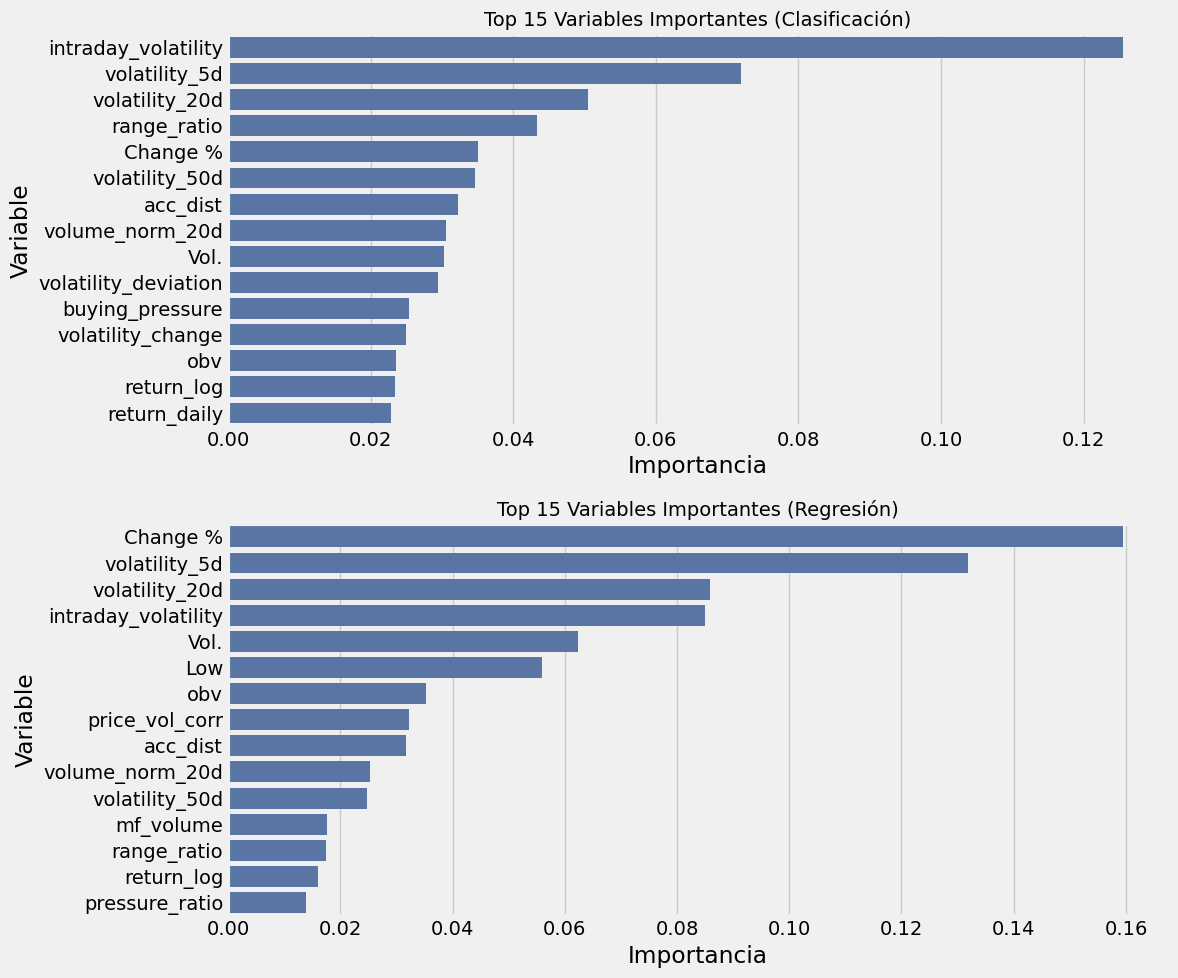

Top 15 características para clasificación:
['intraday_volatility', 'volatility_5d', 'volatility_20d', 'range_ratio', 'Change %', 'volatility_50d', 'acc_dist', 'volume_norm_20d', 'Vol.', 'volatility_deviation', 'buying_pressure', 'volatility_change', 'obv', 'return_log', 'return_daily']

Top 15 características para regresión:
['Change %', 'volatility_5d', 'volatility_20d', 'intraday_volatility', 'Vol.', 'Low', 'obv', 'price_vol_corr', 'acc_dist', 'volume_norm_20d', 'volatility_50d', 'mf_volume', 'range_ratio', 'return_log', 'pressure_ratio']

Características comunes entre los dos modelos:
['Change %', 'volatility_5d', 'intraday_volatility', 'volatility_20d', 'return_log', 'volume_norm_20d', 'range_ratio', 'Vol.', 'acc_dist', 'obv', 'volatility_50d']


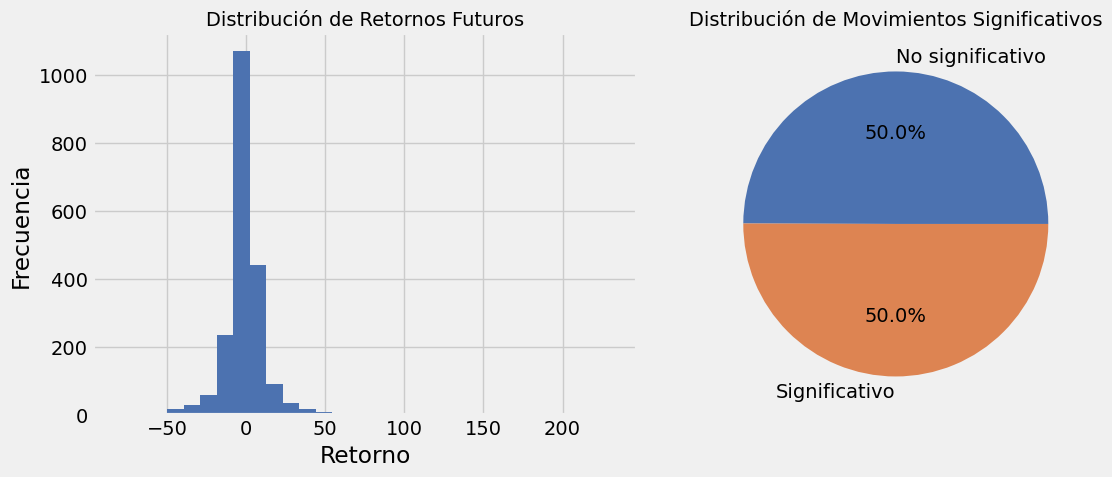

In [39]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


# 1. Preparar variable objetivo para clasificación (movimiento significativo)
# Calculamos los percentiles para determinar movimientos significativos
percentile_75 = data_final_rf['future_return'].quantile(0.75)
percentile_25 = data_final_rf['future_return'].quantile(0.25)

# Creamos variable binaria: 1 para movimientos significativos (alcistas o bajistas), 0 para resto
data_final_rf['significant_move'] = 0
data_final_rf.loc[data_final_rf['future_return'] >= percentile_75, 'significant_move'] = 1
data_final_rf.loc[data_final_rf['future_return'] <= percentile_25, 'significant_move'] = 1

# 2. Preparar variables X (predictores) y Y (objetivo)
# Excluimos columnas que son fugas de información o variables objetivo
target_cols = ['future_return', 'future_range', 'significant_move']
date_cols = ['date'] if 'date' in data_final_rf.columns else []
excluded_cols = target_cols + date_cols

# Identificar columnas categóricas y numéricas
df_temp = data_final_rf.drop(columns=[col for col in excluded_cols if col in data_final_rf.columns])
categorical_cols = df_temp.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df_temp.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Columnas categóricas detectadas: {categorical_cols}")
print(f"Número de columnas numéricas: {len(numerical_cols)}")

# Convertir variables categóricas a numéricas
if categorical_cols:
    # Para visualización, guardar la versión original
    df_display = df_temp.copy()
    
    # Para cada columna categórica, aplicar codificación adecuada
    for col in categorical_cols:
        # Si tiene pocos valores únicos, usar one-hot encoding 
        if df_temp[col].nunique() < 10:
            dummies = pd.get_dummies(df_temp[col], prefix=col, drop_first=False)
            df_temp = pd.concat([df_temp.drop(columns=[col]), dummies], axis=1)
        else:
            # Si tiene muchos valores únicos, usar label encoding
            df_temp[col] = pd.factorize(df_temp[col])[0]

# Seleccionar predictores finales
X = df_temp

# Preparar variables objetivo
y_class = data_final_rf['significant_move']
y_reg = data_final_rf['future_return']

# 3. División de datos con respeto a la temporalidad (ordenados cronológicamente)
# Asumimos que los datos ya están ordenados por fecha
train_size = int(0.7 * len(data_final_rf))
val_size = int(0.15 * len(data_final_rf))

X_train = X[:train_size]
y_class_train = y_class[:train_size]
y_reg_train = y_reg[:train_size]

X_val = X[train_size:train_size+val_size]
y_class_val = y_class[train_size:train_size+val_size]
y_reg_val = y_reg[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_class_test = y_class[train_size+val_size:]
y_reg_test = y_reg[train_size+val_size:]

# 4. Escalar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 5. Entrenar modelos Random Forest para análisis de importancia
# Para clasificación
rf_class = RandomForestClassifier(n_estimators=100, random_state=42)
rf_class.fit(X_train_scaled, y_class_train)

# Para regresión
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_scaled, y_reg_train)

# 6. Extraer y visualizar importancia de características
# Para clasificación
feature_importance_class = pd.DataFrame({
    'feature': X.columns.tolist(),  # Convertir a lista para evitar problemas con índices
    'importance': rf_class.feature_importances_
})
feature_importance_class = feature_importance_class.sort_values('importance', ascending=False)

# Para regresión
feature_importance_reg = pd.DataFrame({
    'feature': X.columns.tolist(),  # Convertir a lista para evitar problemas con índices
    'importance': rf_reg.feature_importances_
})
feature_importance_reg = feature_importance_reg.sort_values('importance', ascending=False)

# 7. Visualizar las 15 características más importantes para cada modelo
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
sns.barplot(x='importance', y='feature', data=feature_importance_class.head(15))
plt.title('Top 15 Variables Importantes (Clasificación)', fontsize=14)
plt.xlabel('Importancia')
plt.ylabel('Variable')

plt.subplot(2, 1, 2)
sns.barplot(x='importance', y='feature', data=feature_importance_reg.head(15))
plt.title('Top 15 Variables Importantes (Regresión)', fontsize=14)
plt.xlabel('Importancia')
plt.ylabel('Variable')

plt.tight_layout()
plt.show()

# 8. Seleccionar las 15 características más importantes para cada modelo
top_features_class = feature_importance_class.head(15)['feature'].tolist()
top_features_reg = feature_importance_reg.head(15)['feature'].tolist()

# Características comunes entre los dos modelos
common_features = list(set(top_features_class) & set(top_features_reg))

print("Top 15 características para clasificación:")
print(top_features_class)
print("\nTop 15 características para regresión:")
print(top_features_reg)
print("\nCaracterísticas comunes entre los dos modelos:")
print(common_features)

# 9. Evaluar distribución de la variable objetivo
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(y_reg, bins=30)
plt.title('Distribución de Retornos Futuros', fontsize=14)
plt.xlabel('Retorno')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
plt.pie([
    (y_class == 0).sum(),
    (y_class == 1).sum()
], labels=['No significativo', 'Significativo'], autopct='%1.1f%%')
plt.title('Distribución de Movimientos Significativos', fontsize=14)

plt.tight_layout()
plt.show()

# 10. Guardar los resultados para uso posterior
# Crear un diccionario con los resultados importantes
results = {
    'feature_importance_class': feature_importance_class,
    'feature_importance_reg': feature_importance_reg,
    'top_features_class': top_features_class,
    'top_features_reg': top_features_reg,
    'common_features': common_features
}

# También podemos guardar este diccionario para uso posterior si es necesario
# import pickle
# with open('feature_importance_results.pkl', 'wb') as f:
#     pickle.dump(results, f)

In [40]:
# Seleccionar top N características para cada modelo
top_n = 10  # Puedes ajustar este número

# Para clasificación
features_class = feature_importance_class['feature'].head(top_n).tolist()
# Para regresión
features_reg = feature_importance_reg['feature'].head(top_n).tolist()

print(f'Features clasificacion{features_class}')
print(f'Features clasificacion{features_reg}')

Features clasificacion['intraday_volatility', 'volatility_5d', 'volatility_20d', 'range_ratio', 'Change %', 'volatility_50d', 'acc_dist', 'volume_norm_20d', 'Vol.', 'volatility_deviation']
Features clasificacion['Change %', 'volatility_5d', 'volatility_20d', 'intraday_volatility', 'Vol.', 'Low', 'obv', 'price_vol_corr', 'acc_dist', 'volume_norm_20d']


In [41]:
import pickle
import json

# Crear un diccionario con las features seleccionadas
selected_features = {
    'features_class': features_class,
    'features_reg': features_reg
}

# Opción 1: Guardar como pickle (formato binario de Python)
with open('selected_features.pkl', 'wb') as f:
    pickle.dump(selected_features, f)

# Opción 2: Guardar como JSON (formato legible en texto)
with open('selected_features.json', 'w') as f:
    json.dump(selected_features, f)

print("Features guardadas correctamente. Puedes cargarlas en tu nuevo notebook 'bitcoin_modelados.ipynb'")

Features guardadas correctamente. Puedes cargarlas en tu nuevo notebook 'bitcoin_modelados.ipynb'


### +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++